*Here we start our code*

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

`age`: age in years

`sex`: sex (1 = male; 0 = female)

`cp`: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic

`trestbps`: resting blood pressure (in mm Hg on admission to the hospital)

`chol`: serum cholestoral in mg/dl

`fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

`restecg`: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

`thalach`: maximum heart rate achieved

`exang`: exercise induced angina (1 = yes; 0 = no)

`oldpeak` = ST depression induced by exercise relative to rest

`slope`: the slope of the peak exercise ST segment -- Value 1: upsloping -- Value 2: flat -- Value 3: downsloping

`ca`: number of major vessels (0-3) colored by flourosopy

`thal`: 3 = normal; 6 = fixed defect; 7 = reversable defect

`num`: diagnosis of heart disease (angiographic disease status) -- Value 0: < 50% diameter narrowing -- Value 1: > 50% diameter narrowing (in any major vessel: attributes 59 through 68 are vessels)

In [5]:
H_D_cleveland <- read_csv("https://raw.githubusercontent.com/TimWei12/Group_25_project/main/processed.cleveland.data",
                          col_names=c("age", "sex", "cp","trestbps", "chol", "fbs", "restecg","thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
filter(ca != "?" & thal != "?")
H_D_cleveland

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


In [6]:
set.seed(3456)
cleveland_split <- initial_split(H_D_cleveland, prop = 0.75, strata = num)  
cleveland_train <- training(cleveland_split)   
cleveland_test <- testing(cleveland_split)
cleveland_train
cleveland_test

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0
48,0,3,130,275,0,0,139,0,0.2,1,0.0,3.0,0
49,1,2,130,266,0,0,171,0,0.6,1,0.0,3.0,0
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
50,0,3,120,219,0,0,158,0,1.6,2,0.0,3.0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0
56,1,3,130,256,1,2,142,1,0.6,2,1.0,6.0,2
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0


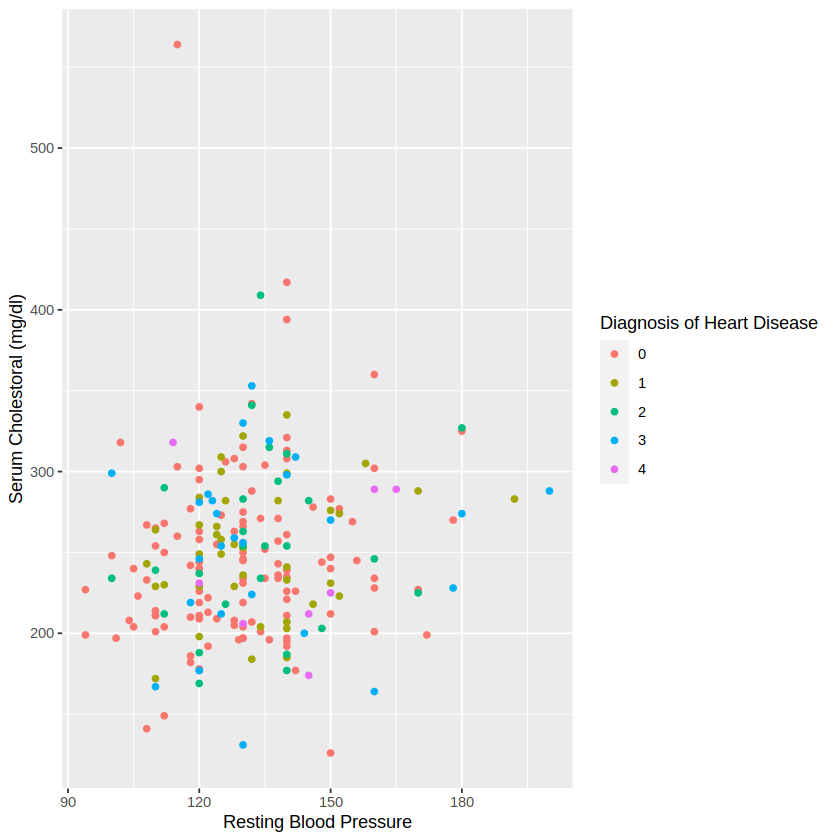

In [7]:
diagnosis_plot_1 <- cleveland_train |>
    mutate(num = as_factor(num)) |>
    ggplot(aes(x=trestbps, y=chol, color=num)) +
    geom_point() +
    labs(x = "Resting Blood Pressure", y = "Serum Cholestoral (mg/dl)", color = "Diagnosis of Heart Disease") +
    scale_fill_distiller(palette="Spectral")
diagnosis_plot_1